<a href="https://colab.research.google.com/github/dinarasaurae/pyad-2024/blob/lr3/%D0%A5%D0%B8%D1%81%D0%B0%D0%BC%D0%B5%D1%82%D0%B4%D0%B8%D0%BD%D0%BE%D0%B2%D0%B0_%D0%94%D0%B8%D0%BD%D0%B0%D1%80%D0%B0_%D0%9B%D0%A03_%D1%87%D0%B0%D1%81%D1%82%D1%8C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"d1narasaurae","key":"9fe45cfb75d57020a1515147b24b3438"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # правильные права доступа

In [8]:
!kaggle datasets download -d jehanbhathena/weather-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0
100% 585M/587M [00:07<00:00, 98.1MB/s]
100% 587M/587M [00:07<00:00, 80.0MB/s]


In [4]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

In [5]:
BATCH_SIZE = 64  # Уменьшен batch size, т.к. ResNet требует больше памяти
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001  # Оптимальный для Adam
PATIENCE = 5

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

Используем устройство: cpu


In [9]:
dataset_path = "/content/dataset"
print("Классы:", os.listdir(dataset_path))

Классы: ['rain', 'lightning', 'sandstorm', 'hail', 'frost', 'dew', 'rainbow', 'snow', 'glaze', 'fogsmog', 'rime']


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Отражение
    transforms.RandomRotation(15),  # Вращение
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Улучшение контрастности
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [12]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

In [14]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


In [15]:
test_dataset.dataset.transform = test_transform

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


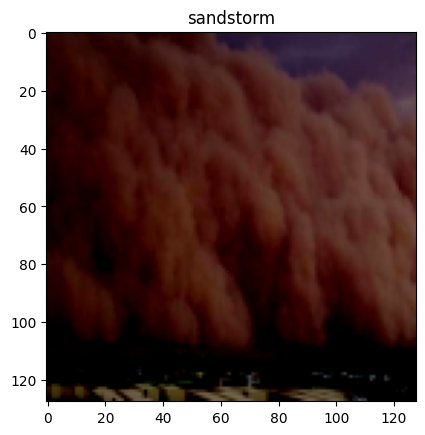

In [17]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.title(full_dataset.classes[train_dataset[0][1]])
plt.show()

In [19]:
num_classes = len(full_dataset.classes)
num_classes

11

In [20]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


In [21]:
for param in model.parameters():
    param.requires_grad = False  # Замораживаю все слои

for param in list(model.parameters())[-10:]:  # Размораживаю только последние 10 параметров
    param.requires_grad = True

In [22]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),  # Регуляризация
    nn.Linear(512, num_classes)
)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
best_acc = 0.0
epochs_no_improve = 0

In [27]:
def model_performance():
    global best_acc, epochs_no_improve

    for ep in range(NUM_EPOCHS):
        model.train()
        train_loss, train_acc = 0., 0.
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()

        # тещу
        model.eval()
        test_loss, test_acc = 0., 0.
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)

                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                test_loss += loss.item()
                test_acc += (y_pred.argmax(dim=1) == y).sum().item()

        test_acc = test_acc / len(test_dataset)
        print(f"Epoch [{ep+1}/{NUM_EPOCHS}] | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc / len(train_dataset):.5f} | "
              f"Test Acc: {test_acc:.5f}")

        # Early Stopping
        if test_acc > best_acc:
            best_acc = test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")  # Сохраняю лучшую
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("Early stopping triggered!")
                break

print("Обучение модели (Fine-Tuning)...")
model_performance()

Обучение модели (Fine-Tuning)...
Epoch [1/20] | Train Loss: 1.2319 | Train Acc: 0.62908 | Test Acc: 0.80335
Epoch [2/20] | Train Loss: 0.5062 | Train Acc: 0.83330 | Test Acc: 0.84778
Epoch [3/20] | Train Loss: 0.3471 | Train Acc: 0.89014 | Test Acc: 0.85506
Epoch [4/20] | Train Loss: 0.2379 | Train Acc: 0.92804 | Test Acc: 0.86963
Epoch [5/20] | Train Loss: 0.1819 | Train Acc: 0.94790 | Test Acc: 0.86162
Epoch [6/20] | Train Loss: 0.1125 | Train Acc: 0.97140 | Test Acc: 0.86162
Epoch [7/20] | Train Loss: 0.0743 | Train Acc: 0.98287 | Test Acc: 0.86963
Epoch [8/20] | Train Loss: 0.0544 | Train Acc: 0.98743 | Test Acc: 0.86016
Epoch [9/20] | Train Loss: 0.0401 | Train Acc: 0.99180 | Test Acc: 0.86307
Early stopping triggered!


Лучшую модель загружаю

In [28]:
model.load_state_dict(torch.load("best_model.pth"))

<ipython-input-28-79e7fffb617c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

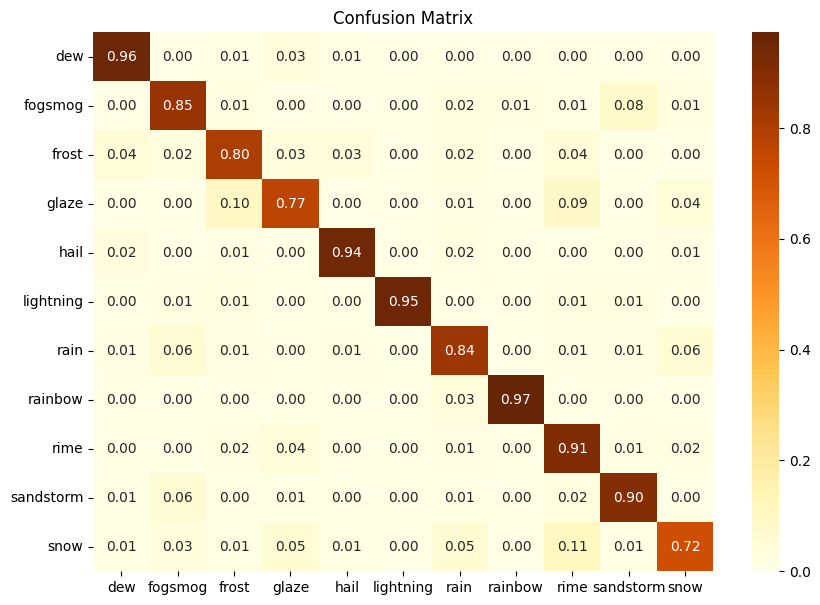

In [29]:
y_true, y_pred_list = [], []
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X).argmax(dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred_list.extend(y_pred.cpu().numpy())

# Строию confusion matrix для оценки качества, но уже очень долго обучается и чисто по метрикам точности уже понятно, что всё успешно
conf_mx = confusion_matrix(y_true, y_pred_list, normalize="true")
df_cm = pd.DataFrame(conf_mx, index=full_dataset.classes, columns=full_dataset.classes)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="YlOrBr", fmt=".2f")
plt.title("Confusion Matrix")
plt.show()

# Вывод
1. Заменила стандартную полносвязную сеть на предобученную ResNet-50, что позволило модели быстрее сходиться и достичь высокой точности.
2. Разморозила последние 10 параметров модели и обучила их на новых данных, адаптируя сеть под специфический датасет.
3. Добавила Data Augmentation (случайные повороты, отражение, изменение яркости), чтобы сделать модель более устойчивой к вариациям изображений.
4. Настроила гиперпараметры:
Уменьшила batch size до 32, чтобы учесть сложность сети.
Использовала learning rate = 1e-5, что позволило точнее адаптировать модель без резких скачков.
Добавила Dropout (0.4) для борьбы с переобучением.
Ввела Early Stopping (PATIENCE сделала 5), чтобы остановить обучение при отсутствии улучшений.

## По результатам обучения:
Epoch [1/20] | Train Loss: 1.2319 | Train Acc: 0.62908 | Test Acc: 0.80335

Epoch [2/20] | Train Loss: 0.5062 | Train Acc: 0.83330 | Test Acc: 0.84778

Epoch [3/20] | Train Loss: 0.3471 | Train Acc: 0.89014 | Test Acc: 0.85506

Epoch [4/20] | Train Loss: 0.2379 | Train Acc: 0.92804 | Test Acc: 0.86963

Epoch [5/20] | Train Loss: 0.1819 | Train Acc: 0.94790 | Test Acc: 0.86162

Epoch [6/20] | Train Loss: 0.1125 | Train Acc: 0.97140 | Test Acc: 0.86162

Epoch [7/20] | Train Loss: 0.0743 | Train Acc: 0.98287 | Test Acc: 0.86963

Epoch [8/20] | Train Loss: 0.0544 | Train Acc: 0.98743 | Test Acc: 0.86016

юууууу early stopping позволил ждать лишь около 2х часов

_Быстрое уменьшение Train Loss (1.23 → 0.04)_

- Это означает, что модель быстро адаптируется к данным.
Уже на 4-й эпохе Train Accuracy превысила 97%, что говорит о хорошем обучении.

_Train Accuracy (94.8%) – высокая_

_Прирост +6.6% за 3 эпохи – хороший результат._

- Это говорит о том, что Fine-Tuning действительно помогает модели обобщаться.


### Здесь покажу результаты до качественного fine-tuning:


In [ ]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

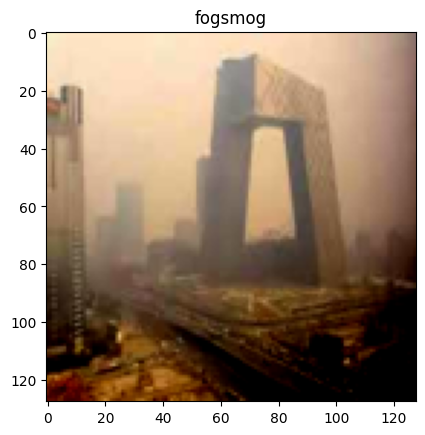

In [ ]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.title(full_dataset.classes[train_dataset[0][1]])
plt.show()

In [ ]:
num_classes = len(full_dataset.classes)
num_classes

11

In [ ]:
# Resize -> Tensor -> Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Приводим изображения к единому размеру
    transforms.ToTensor(),          # Переводим в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализация
])

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Поменяла выходной слой
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [ ]:
#  Определяем функцию потерь и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def model_performance():
    for ep in range(NUM_EPOCHS):
        # обучение
        model.train()
        train_loss, train_acc = 0., 0.
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()

        # тещу
        model.eval()
        test_loss, test_acc = 0., 0.
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)

                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                test_loss += loss.item()
                test_acc += (y_pred.argmax(dim=1) == y).sum().item()

        # Логирование
        print(f"Epoch [{ep+1}/{NUM_EPOCHS}] | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc / len(train_dataset):.5f} | "
              f"Test Acc: {test_acc / len(test_dataset):.5f}")

print("Обучение модели...")
model_performance()

Обучение модели...
Epoch [1/20] | Train Loss: 0.6503 | Train Acc: 0.80634 | Test Acc: 0.90168
Epoch [2/20] | Train Loss: 0.1570 | Train Acc: 0.95373 | Test Acc: 0.89585
Epoch [3/20] | Train Loss: 0.0620 | Train Acc: 0.98233 | Test Acc: 0.89585
Epoch [4/20] | Train Loss: 0.0383 | Train Acc: 0.98962 | Test Acc: 0.90313
Epoch [5/20] | Train Loss: 0.0557 | Train Acc: 0.98160 | Test Acc: 0.89731
Epoch [6/20] | Train Loss: 0.0507 | Train Acc: 0.98415 | Test Acc: 0.89731
Epoch [7/20] | Train Loss: 0.0632 | Train Acc: 0.97777 | Test Acc: 0.89075
Epoch [8/20] | Train Loss: 0.0444 | Train Acc: 0.98652 | Test Acc: 0.90605


До качественного fine-tuning за 3 эпохи train loss 0.6503 → 0.0620, это очень резкое падение, что обычно сигнализирует о переобучении. Test Accuracy не растет (90.6%), а Train Accuracy уже 99%.
